In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

seaborn 0.10.1
numpy   1.18.4
pandas  1.0.4



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import shap

import pandas as pd
import requests

from io import StringIO

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
from collections import defaultdict

url = requests.get('https://docs.google.com/spreadsheets/d/1KO_wGiEagJ8PMO2BzSDI1IXHYO4RHZMMSWXlT48peiQ/export?format=csv')
csv_raw = StringIO(url.text)
df_truth = pd.read_csv(csv_raw)

inf_tax_file = "/mnt/btrfs/data/gtdb_95/gtdb_genomes_reps_r95/r95.gtdb.tax"

# Building the true species dataset

In [4]:
df_tax = pd.read_csv(inf_tax_file, names=["assembly_accession", "tax"], sep="\t")

df_tax["species"] = [";".join(_.split(";")[:7]) for _ in df_tax.tax]
df_tax["genus"] = [";".join(_.split(";")[:6]) for _ in df_tax.tax]
df_tax["family"] = [";".join(_.split(";")[:5]) for _ in df_tax.tax]

In [5]:
dd = dict()
for group, df in df_truth.groupby('dataset'):
    dd[group] = set(df["database_accession"].values)
    if np.nan in dd[group]:
        dd[group].remove(np.nan)

In [6]:
from glob import glob
import os

files = glob("/mnt/btrfs/data/type_1/species_mc/b6_split_by_sample/*.extra.csv")

dfs = []
for file in files:
    name = '_'.join(os.path.basename(file).split('.')[:-3])
    if name == "test_sort":
        continue
    df = pd.read_csv(file, index_col = 0)
    df['dataset'] = name
    dfs.append(df)
df_type_1_features = pd.concat(dfs)

Columns (84,88,97,106) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (47,49,55,56,57,58,70,83,95,96,100,103,104,108,109) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (70,83,95,96,100,103,104,108,109) have mixed types.Specify dtype option on import or set low_memory=False.


In [7]:
rows = []
for t in df_type_1_features.itertuples():
    if t.assembly_accession in dd[t.dataset]:
        rows.append(True)
    else:
        rows.append(False)
df_type_1_features["truth"] = rows

In [8]:
df_type_1_features['truth'].sum()

122

In [9]:
# mask_eubacterium = [_ in eubacteriums for _ in df_type_1_features['assembly_accession']]

In [10]:
df_type_1_features.groupby('truth').mean()

,hits,percent_coverage,mean_coverage,sd_coverage,percent_padded_coverage,mean_padded_coverage,sd_padded_coverage,percent_binned_coverage,mean_binned_coverage,sd_binned_coverage,...,gf_mean_scaffold_length,gf_n50_contigs,gf_n50_scaffolds,gf_protein_count,gf_scaffold_count,gf_ssu_count,gf_total_gap_length,gf_trna_aa_count,gf_trna_count,gf_trna_selenocysteine_count
truth,,,,,,,,,,,,,,,,,,,,,
False,3.239319e+03,0.000875,0.092289,2.531930,0.001534,0.154517,3.746302,0.002177,0.323931,6.280481,...,8.061090e+05,1.094139e+06,1.250438e+06,3818.894454,76.263736,2.158391,9811.494846,19.337915,51.752234,0.161085
True,1.880543e+06,0.703774,85.043975,99.475321,0.751646,113.741787,118.544562,0.786987,188.054088,191.574473,...,2.212078e+06,2.763453e+06,2.922896e+06,3310.090164,13.737705,4.311475,5892.532787,19.581967,59.286885,0.139344


In [11]:
df_type_1_features.groupby('dataset').mean()

,hits,percent_coverage,mean_coverage,sd_coverage,percent_padded_coverage,mean_padded_coverage,sd_padded_coverage,percent_binned_coverage,mean_binned_coverage,sd_binned_coverage,...,gf_n50_contigs,gf_n50_scaffolds,gf_protein_count,gf_scaffold_count,gf_ssu_count,gf_total_gap_length,gf_trna_aa_count,gf_trna_count,gf_trna_selenocysteine_count,truth
dataset,,,,,,,,,,,,,,,,,,,,,
dual_index,99.186609,0.001536,0.004886,0.052115,0.001993,0.006192,0.070818,0.002589,0.009919,0.106076,...,1.129564e+06,1.294797e+06,3807.313737,69.550468,2.265561,10889.223855,19.431568,52.481377,0.155392,0.001193
gis_20,19253.052920,0.002234,0.586960,11.445821,0.002878,0.893255,16.024400,0.003691,1.925302,29.261207,...,1.127082e+06,1.277582e+06,3916.328516,77.123373,2.143669,6616.306147,19.360873,51.803942,0.162744,0.001010
hmp_even,1165.422709,0.002070,0.026119,0.671371,0.003497,0.073089,1.383517,0.004409,0.116542,1.978580,...,1.036182e+06,1.183016e+06,3798.242926,83.113132,2.005308,9276.677129,19.196538,50.275467,0.163720,0.000969
hmp_staggered,652.053147,0.001033,0.012736,0.459527,0.002010,0.041127,1.011300,0.002785,0.065205,1.435355,...,1.057824e+06,1.207405e+06,3821.154354,81.732126,2.043972,9402.177458,19.252472,50.632297,0.167380,0.000998
mbarc_26,6937.558789,0.002394,0.408469,1.163047,0.002622,0.382670,1.124678,0.003124,0.693755,1.796629,...,1.135078e+06,1.306175e+06,3898.536280,79.262254,2.324745,12627.015178,19.385977,54.081964,0.177699,0.001925
zymo_even,559.568718,0.001024,0.026347,0.308280,0.001395,0.032079,0.377924,0.001870,0.055957,0.594392,...,1.106914e+06,1.267416e+06,3743.073659,69.400121,2.226796,10587.274386,19.409942,52.195089,0.148348,0.000485
zymo_log,7514.998980,0.000722,0.234523,3.888986,0.001169,0.478779,6.214730,0.001690,0.751497,8.552841,...,1.110680e+06,1.269649e+06,3750.678970,69.803925,2.229324,10524.154483,19.405714,52.059537,0.152263,0.000480


In [12]:
list(df_type_1_features.columns)

['assembly_accession',
 'hits',
 'percent_coverage',
 'mean_coverage',
 'sd_coverage',
 'percent_padded_coverage',
 'mean_padded_coverage',
 'sd_padded_coverage',
 'percent_binned_coverage',
 'mean_binned_coverage',
 'sd_binned_coverage',
 'expected_percent_coverage',
 'shannon_entropy',
 'percent_max_uncovered_region',
 'largest_pileup',
 'largest_padded_pileup',
 'largest_binned_pileup',
 'gc_content',
 'total_genome_length',
 'ungapped_genome_length',
 'num_n_groups',
 'consecutive_ns',
 'gf_accession',
 'gf_ambiguous_bases',
 'gf_checkm_completeness',
 'gf_checkm_contamination',
 'gf_checkm_marker_count',
 'gf_checkm_marker_lineage',
 'gf_checkm_marker_set_count',
 'gf_checkm_strain_heterogeneity',
 'gf_coding_bases',
 'gf_coding_density',
 'gf_contig_count',
 'gf_gc_count',
 'gf_gc_percentage',
 'gf_genome_size',
 'gf_gtdb_genome_representative',
 'gf_gtdb_representative',
 'gf_gtdb_taxonomy',
 'gf_gtdb_type_designation',
 'gf_gtdb_type_designation_sources',
 'gf_gtdb_type_species

In [13]:
# df_type_1_features[~np.isfinite(df_type_1_features['shannon_entropy'])]

In [14]:
features = ['hits',
 'percent_coverage',
 'mean_coverage',
 'sd_coverage',
 'percent_binned_coverage',
 'mean_binned_coverage',
 'sd_binned_coverage',
 'expected_percent_coverage',
 'shannon_entropy',
 'percent_max_uncovered_region',
 'largest_pileup',
 'largest_binned_pileup',
 'gc_content',
 'total_genome_length',
 'ungapped_genome_length',
 'num_n_groups',
 'consecutive_ns']

In [15]:
X_type_1 = df_type_1_features[features + ["assembly_accession", "dataset", "truth"]]
                                                 
X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
X_type_1 = X_type_1.dropna()

print(X_type_1.groupby('dataset').sum())

y = X_type_1["truth"]
X_type_1 = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "truth"])]


X_type_1_train, X_type_1_test, y_train, y_test = train_test_split(X_type_1, y, random_state=42)

                    hits  percent_coverage  mean_coverage    sd_coverage  \
dataset                                                                    
dual_index       1579150         24.456719      77.797533     829.716959   
gis_20         362361709         42.052061   11047.181289  215421.796525   
hmp_even        25248883         44.848096     565.878501   14545.256815   
hmp_staggered   13716590         21.731233     267.918649    9666.614768   
mbarc_26        93698669         32.331114    5516.780499   15708.117984   
zymo_even        9230086         16.898517     434.592579    5085.070763   
zymo_log       125214913         12.027565    3907.630176   64798.277804   

               percent_binned_coverage  mean_binned_coverage  \
dataset                                                        
dual_index                     41.2142              157.9145   
gis_20                         69.4660            36236.1049   
hmp_even                       95.5295             2524.881

In [16]:
clf = RandomForestClassifier(random_state=42)

clf.fit(X_type_1_train, y_train)

RandomForestClassifier(random_state=42)

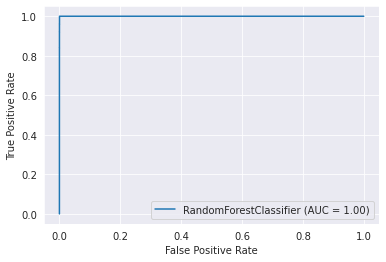

In [17]:
clf_disp = plot_roc_curve(clf, X_type_1_test, y_test)
plt.show()

In [18]:
# X_type_1["truth"] = y
# sns.pairplot(X_type_1, hue="truth")

In [19]:
# explainer = shap.TreeExplainer(clf, X_type_1_train)

# shap_values = explainer.shap_values(X_type_1_train)
# shap.summary_plot(shap_values, X_type_1_train, show=False)
# fig = plt.gcf()

In [20]:
y_preds = clf.predict(X_type_1)

accuracy = (y_preds == y).sum() / (y.shape[0])

print(accuracy)

0.999943596602904


In [21]:
y_preds.sum()

121

In [22]:
y.sum()

122

In [23]:
# X_type_1 = df_type_1_features.loc[:, df_type_1_features.columns.difference(["shannon_entropy"])]
                                                 
# X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
# X_type_1 = X_type_1.dropna()

# print(X_type_1.groupby('dataset').sum())

In [24]:
df_type_1_features["dataset"].unique()

array(['dual_index', 'zymo_even', 'mbarc_26', 'hmp_staggered', 'hmp_even',
       'zymo_log', 'gis_20'], dtype=object)

In [25]:
X_type_1

,consecutive_ns,expected_percent_coverage,gc_content,hits,largest_binned_pileup,largest_pileup,mean_binned_coverage,mean_coverage,num_n_groups,percent_binned_coverage,percent_coverage,percent_max_uncovered_region,sd_binned_coverage,sd_coverage,shannon_entropy,total_genome_length,ungapped_genome_length
0,20,0.381278,0.296336,17764,93,41,1.7764,0.480100,263,0.6127,0.286522,0.006250,2.645071,1.084750,1.319804,5786732,5781472
1,20,0.991119,0.328377,75106,93,79,7.5106,4.723867,1,0.9648,0.917861,0.010597,6.453858,4.746405,3.603182,2782582,2782562
2,20,0.956147,0.322877,44393,100,74,4.4393,3.126904,1,0.9246,0.841959,0.001599,5.501319,4.304550,3.153507,2427061,2427041
3,0,0.850406,0.388256,18880,70,61,1.8880,1.899831,0,0.4707,0.413234,0.013428,3.518843,3.718532,2.404319,1680937,1680937
4,0,0.521883,0.387727,8131,29,39,0.8131,0.737899,0,0.2872,0.227315,0.016710,2.031199,2.088014,1.422032,1663456,1663456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18816,20,0.000056,0.424080,1,1,1,0.0001,0.000056,52,0.0001,0.000056,0.999944,0.009999,0.007451,0.000865,1296795,1295755
18817,20,0.000033,0.578566,1,1,1,0.0001,0.000033,267,0.0001,0.000033,0.999967,0.009999,0.005758,0.000541,2111093,2105753
18818,20,0.000017,0.613526,1,1,1,0.0001,0.000017,25,0.0001,0.000017,0.999983,0.009999,0.004080,0.000288,4204433,4203942
18819,94,0.000008,0.408442,1,1,1,0.0001,0.000008,135,0.0001,0.000008,0.999992,0.009999,0.002789,0.000143,9000566,8997742


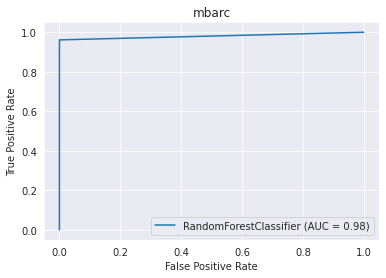

Precision: 0.96
Recall: 0.9230769230769231


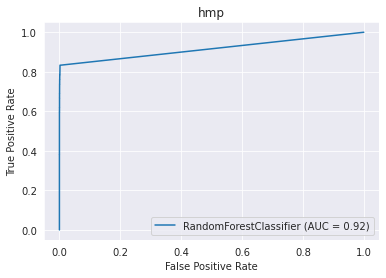

Precision: 0.8064516129032258
Recall: 0.5681818181818182


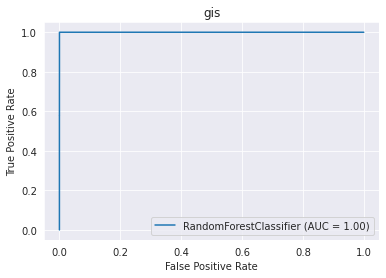

Precision: 0.7916666666666666
Recall: 0.95


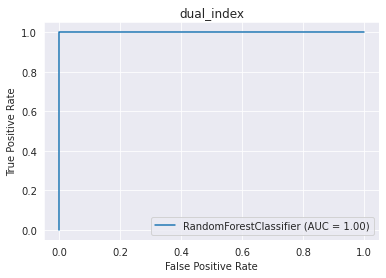

Precision: 0.8823529411764706
Recall: 0.75


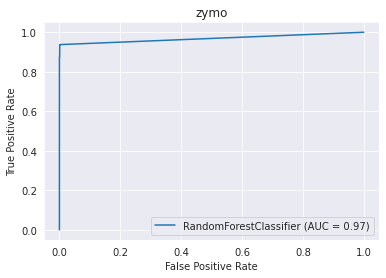

Precision: 1.0
Recall: 0.55


In [26]:
# ra_mask = df_capitalist_species["relative_abundace"] > .005

# df_c_ra = df_capitalist_species[ra_mask]

for dataset in ["mbarc", "hmp", "gis", "dual_index", "zymo"]:
    
    X_type_1 = df_type_1_features[features + ["assembly_accession", "dataset", "truth"]]
                                                 
    X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
    X_type_1 = X_type_1.dropna()
    
    mask_dataset = np.array([_.startswith(dataset) for _ in X_type_1["dataset"]])

    y = X_type_1["truth"]
    X_type_1 = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "truth"])]
    
    X_type_1_train = X_type_1.loc[~mask_dataset, :]
    X_type_1_test =  X_type_1.loc[mask_dataset, :]
    y_train = y.loc[~mask_dataset]
    y_test = y.loc[mask_dataset]
    
    df_train = df_type_1_features[~mask_dataset]
    df_test = df_type_1_features[mask_dataset]  
    
    clf = RandomForestClassifier(random_state=42)

    clf.fit(X_type_1_train, y_train)
    
    
    clf_disp = plot_roc_curve(clf, X_type_1_test, y_test)
    plt.title(dataset)
    plt.show()
    
    y_test_preds = clf.predict(X_type_1_test)
    
    precision = y_test[y_test_preds].sum() / y_test_preds.sum()
    
    print("Precision:", precision)
    
    recall = y_test[y_test_preds].sum() / df_truth["dataset"].str.startswith(dataset).sum()
    
    print("Recall:", recall)
    
    fps = y_test_preds & ~y_test
    
    aa_fps = df_test.loc[fps, "assembly_accession"]
    
    tps = y_test_preds & y_test
    
    aa_tps = df_test.loc[tps, "assembly_accession"]
    
    fns = ~y_test_preds & y_test
    
    aa_fns = df_test.loc[fns, "assembly_accession"]
#     break
    
#     mask_ra = df_c_ra["dataset"].str.startswith(dataset)
    
#     df_masked = df_c_ra.loc[mask_ra, :]
    
#     precision_cap = df_masked["truth"].sum() / df_masked.shape[0]
    
#     print("Precision Capitalist:", precision_cap)
    
#     recall_cap = df_masked["truth"].sum() / df_truth["dataset"].str.startswith(dataset).sum()
    
#     print("Recall Capitalist:", recall_cap)

In [27]:
dataset

'zymo'

In [28]:
fn_mask = [_ in set(aa_fns) for _ in df_tax["assembly_accession"]]
fn_tax = list(df_tax.loc[fn_mask, "species"].values)
fn_tax = sorted(fn_tax)
for _ in fn_tax:
    print(_)

k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus_faecalis
k__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus_aureus
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_flexneri
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Salmonella;s__Salmonella_enterica


In [29]:
tp_mask = [_ in set(aa_tps) for _ in df_tax["assembly_accession"]]
tp_tax = list(df_tax.loc[tp_mask, "species"].values)
tp_tax = sorted(tp_tax)
for _ in tp_tax:
    print(_)

k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus_marinus
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus;s__Enterococcus_faecalis
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Limosilactobacillus;s__Limosilactobacillus_fermentum
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria_monocytogenes_B
k__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus_aureus
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Salmonella;s__Salmonella_enterica
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__Pseudomonas_aeruginosa
